# Purpose

This notebook explores the statistical properties of SPY returns and volatility, and motivates the modelling choices used in subsequent forecasting exercises.

The goal is to determine whether returns and volatility can be modelled separately for forecasting and risk estimation purposes.

# Load processed data

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_arch

In [28]:
returns_df = pd.read_csv(
    "../data/processed/daily_returns.csv",
    index_col=0,
    parse_dates=True
)
returns_df.index = pd.to_datetime(returns_df.index)
returns_df = returns_df.sort_index()
returns_df.head()

,Adj Close,adj_return,adj_log_return
Date,,,
2010-01-05,85.253036,0.002647,0.002644
2010-01-06,85.313065,0.000704,0.000704
2010-01-07,85.673187,0.004221,0.004212
2010-01-08,85.958298,0.003328,0.003322
2010-01-11,86.078316,0.001396,0.001395


# Summary statistics of returns

In [29]:
returns_df["adj_log_return"].describe()

count    3773.000000
mean        0.000509
std         0.010772
min        -0.115886
25%        -0.003716
50%         0.000682
75%         0.005773
max         0.086731
Name: adj_log_return, dtype: float64

In [30]:
returns_df["adj_log_return"].skew()

np.float64(-0.7215097289571919)

In [31]:
returns_df["adj_log_return"].kurtosis()

np.float64(11.544439782747663)

+ Mean ≈ 0

+ Negative skew

+ Very high kurtosis

+ Non-normal distribution

Heavy tails imply that Gaussian assumptions will underestimate tail risk, particularly for volatility-based risk measures.

In [ ]:
# Top 5 extreme return dates
extreme_events = returns_df.loc[returns_df["adj_log_return"].abs().nlargest(5).index]
extreme_events[["adj_log_return"]].style

,adj_log_return
Date,
2020-03-16 00:00:00,-0.115886
2020-03-12 00:00:00,-0.100569
2020-03-24 00:00:00,0.086731
2020-03-13 00:00:00,0.082028
2020-03-09 00:00:00,-0.081312


COVID-19 Pandemic (March 2020)

# Return distribution

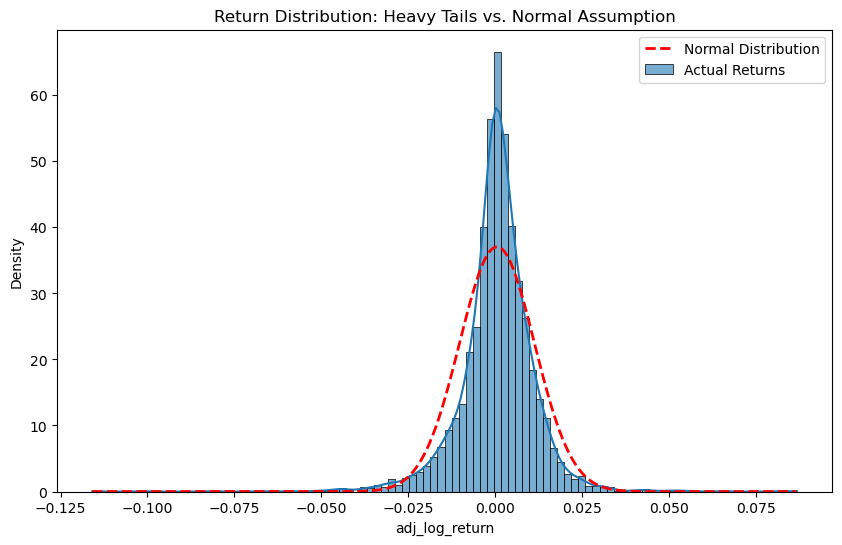

In [33]:
plt.figure(figsize=(10, 6))
sns.histplot(returns_df["adj_log_return"], bins=100, kde=True, stat="density", label="Actual Returns", alpha=0.6)

# Overlay Theoretical Normal
mu, std = returns_df["adj_log_return"].mean(), returns_df["adj_log_return"].std()
x = np.linspace(returns_df["adj_log_return"].min(), returns_df["adj_log_return"].max(), 500)
plt.plot(x, norm.pdf(x, mu, std), color='red', lw=2, linestyle='--', label="Normal Distribution")

plt.title("Return Distribution: Heavy Tails vs. Normal Assumption")
plt.legend()
plt.show()

# Stationarity check on returns

In [34]:
adf_result = adfuller(returns_df["adj_log_return"])
pd.Series(
    adf_result[:4],
    index=["ADF Statistic", "p-value", "Lags Used", "Observations"]
)

ADF Statistic   -1.333221e+01
p-value          6.151290e-25
Lags Used        2.600000e+01
Observations     3.746000e+03
dtype: float64

ADF rejects unit root

In [59]:
kpss_stat, pval, lags, crit = kpss(returns_df["adj_log_return"], regression="c", nlags="auto")

print("KPSS stat:", kpss_stat)
print("p-value (capped):", pval)
print("lags:", lags)
print("critical values:", crit)

KPSS stat: 0.023539244088709083
p-value (capped): 0.1
lags: 29
critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


C:\Users\Administrator\AppData\Local\Temp\ipykernel_16624\1079714772.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, pval, lags, crit = kpss(returns_df["adj_log_return"], regression="c", nlags="auto")


KPSS fails to reject stationarity

As expected for equity returns, the series is stationary and does not require further transformation.

# Return autocorrelation diagnostics

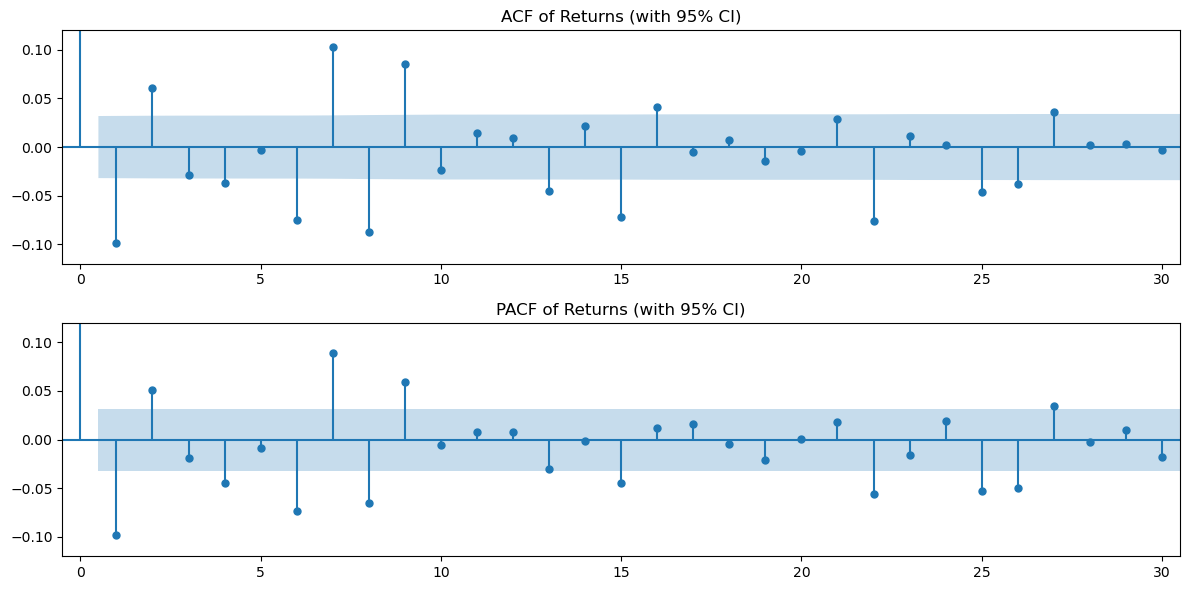

In [50]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))

plot_acf(returns_df["adj_log_return"], lags=30, ax=ax[0])
ax[0].set_title("ACF of Returns (with 95% CI)")
ax[0].set_ylim(-0.12, 0.12)
ax[0].set_xlim(-0.5, 30.5)

plot_pacf(returns_df["adj_log_return"], lags=30, ax=ax[1], method="ywm")
ax[1].set_title("PACF of Returns (with 95% CI)")
ax[1].set_ylim(-0.12, 0.12)
ax[1].set_xlim(-0.5, 30.5)

plt.tight_layout()

plt.savefig(
    "../outputs/figures/correlogram_of_returns.png",
    dpi=150
)

plt.show()

Most autocorrelations are very close to zero and any spikes look small and die out quickly

In [57]:
lb_residuals = acorr_ljungbox(returns_df["adj_log_return"], lags=[10, 20, 30], return_df=True)
print(lb_residuals[['lb_stat', 'lb_pvalue']])

       lb_stat     lb_pvalue
10  177.891442  6.418029e-33
20  215.645081  8.817606e-35
30  259.445404  2.254831e-38


Ljung–Box test find significant autocorrelation

While statistically significant due to sample size, the magnitude of autocorrelations is weak, short-lived and economically negligible.

# Volatility clustering diagnostics

In [ ]:
returns_df["squared_returns"] = returns_df["adj_log_return"] ** 2

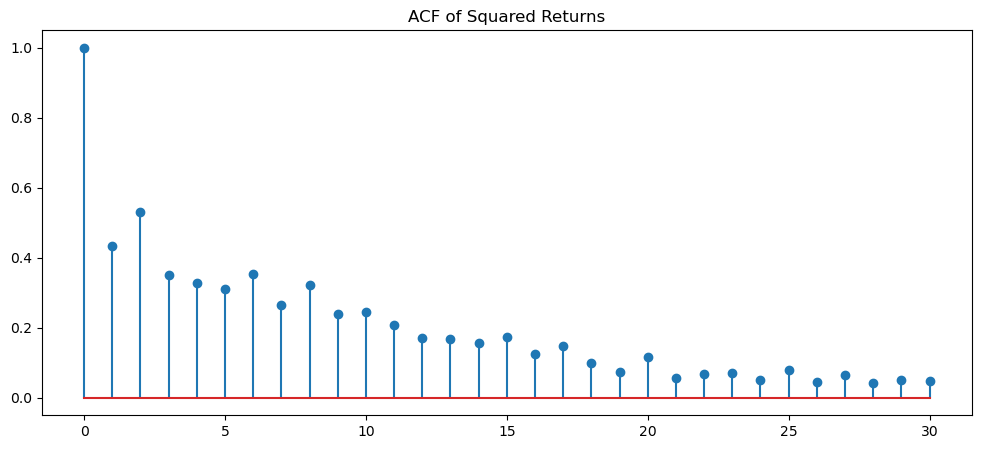

In [55]:
plt.figure(figsize=(12, 5))
plt.stem(acf(returns_df["squared_returns"], nlags=30))
plt.title("ACF of Squared Returns")
plt.show()

In [56]:
lb_sq_residuals = acorr_ljungbox(returns_df["squared_returns"], lags=[10, 20, 30], return_df=True)
print(lb_sq_residuals[['lb_stat', 'lb_pvalue']])

        lb_stat  lb_pvalue
10  4587.766810        0.0
20  5428.745606        0.0
30  5560.993008        0.0


In [41]:
arch_test = het_arch(returns_df["adj_log_return"].dropna())
results = pd.Series(arch_test, index=["LM Statistic", "p-value", "F-Statistic", "F p-value"])
print("Engle's ARCH Test Results:")
print(results)

Engle's ARCH Test Results:
LM Statistic     1.361320e+03
p-value         2.224559e-286
F-Statistic      2.126708e+02
F p-value        0.000000e+00
dtype: float64


Significant autocorrelation in squared returns

Evidence of volatility clustering

This justifies modelling conditional variance separately from the mean (GARCH).

# Construct realised volatility

In [42]:
# 21-day rolling realised volatility
returns_df["realised_vol_21d"] = (
    returns_df["adj_log_return"]
    .rolling(window=21) # 21 trading days ~ 1 month
    .std()
)

In [43]:
returns_df_vol = returns_df.dropna()

In [44]:
returns_df_vol.head()

,Adj Close,adj_return,adj_log_return,squared_returns,realised_vol_21d
Date,,,,,
2010-02-03,82.402016,-0.004983,-0.004995,0.000025,0.010381
2010-02-04,79.858582,-0.030866,-0.031353,0.000983,0.012195
2010-02-05,80.023689,0.002068,0.002065,0.000004,0.012220
2010-02-08,79.445946,-0.007220,-0.007246,0.000053,0.012136
2010-02-09,80.443810,0.012560,0.012482,0.000156,0.012554


This realised volatility measure is backward-looking and serves as a noisy proxy for latent volatility.

# Realised volatility behaviour

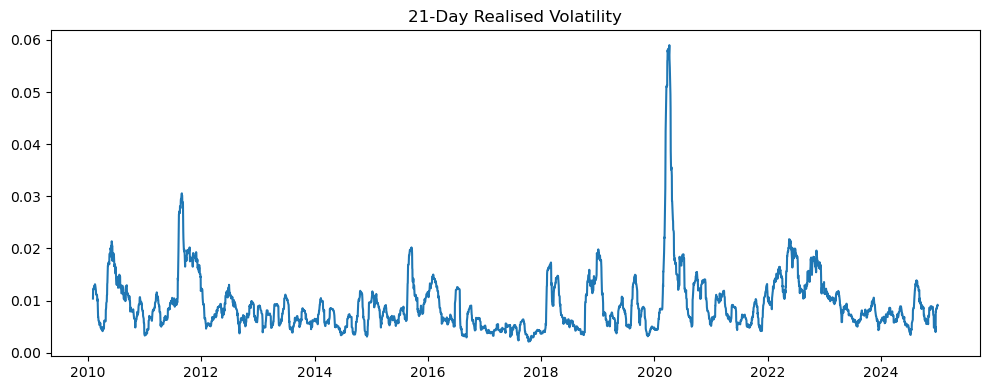

In [45]:
plt.figure(figsize=(10, 4))
plt.plot(returns_df_vol.index, returns_df_vol["realised_vol_21d"])
plt.title("21-Day Realised Volatility")
plt.tight_layout()
plt.show()

# Save transformed datasets

In [46]:
returns_df_vol[["adj_log_return", "realised_vol_21d"]].to_csv(
    "../data/processed/realised_volatility_21d.csv"
)

# Summary

+ Daily log returns are stationary with weak autocorrelation

+ Squared returns show significant persistence

+ Volatility exhibits clustering and smooth dynamics

+ Separate modelling of mean and variance is appropriate